#### Perform a variety of pre-processing steps on images

* Image Loading
* Image Resizing (All images are 224 X 224 X 3 in jpg format)
* Image Cropping (All images in the dataset have been cropped so that only the image of a single card is present and the card occupies well over 50% of the pixels in the image)
* Convert to Grayscale 
* Image Enhancement (histogram equalization, sharpening, noise reduction, etc.)
* Normalization
* Data Augmentation: Apply data augmentation techniques to increase the size and diversity of your dataset. This can include random rotations, flips, translations, or other transformations to simulate different viewpoints or variations in lighting conditions.
* Image Filtering: : Apply filters or convolutions to smooth the image or enhance specific features. This can include techniques such as blurring (e.g., Gaussian blur), edge detection (e.g., Sobel, Canny), or other spatial filters.


In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from sklearn.model_selection import train_test_split

from scipy.ndimage import convolve, binary_fill_holes
from scipy.stats import mode

from skimage import io, exposure
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.transform import rotate, hough_line, hough_line_peaks, resize
from skimage.filters import threshold_otsu, sobel, gaussian, threshold_local


import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam


from glob import glob


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score

2023-07-16 02:31:22.315482: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-16 02:31:22.585449: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Image Loading

In [2]:
# Load images from csv file

path = pd.read_csv('Dataset/cards.csv')
path_df = pd.DataFrame(path)
# For column names that contain space, replace the space with an underscore
path_df.columns = [c.replace(' ', '_') for c in path_df.columns]
path_df.head()

,class_index,filepaths,labels,card_type,data_set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


In [3]:
path_df['suit'] = path_df['labels'].str.split().str[-1]
print(path_df['suit'].unique())

['clubs' 'diamonds' 'hearts' 'spades' 'joker']


In [4]:
# Remove rows with jokers
path_df = path_df[~path_df['suit'].str.contains('joker', case=False)]
print("Unique suits without Jokers: ", path_df['suit'].unique())

Unique suits without Jokers:  ['clubs' 'diamonds' 'hearts' 'spades']


In [5]:
path_df.head()

,class_index,filepaths,labels,card_type,data_set,suit
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train,clubs
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train,clubs
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train,clubs
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train,clubs
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train,clubs


## Check Image Size

In [6]:
# All images are 224 X 224 X 3 in jpg format
# Double check by printing out unique shapes of images

image_shapes = []

for folder in path_df.data_set.unique():
    for filepath in path_df[path_df.data_set == folder].filepaths:
        image = cv2.imread('Dataset/' + filepath)

        if (filepath[-3:] == "jpg"):

            # Obtain shape of each image and store them in an array
            (width, height) = image.shape[1], image.shape[0]
            image_shapes.append((width, height))
    
# Return only unique shapes
unique_shapes = list(set(image_shapes))
print(unique_shapes)


[(224, 224)]


## Convert Images to Grayscale

In [7]:
# Convert images to grayscale

def convert_to_grayscale(filepath):
    filename = 'Dataset/' + filepath
    image = cv2.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

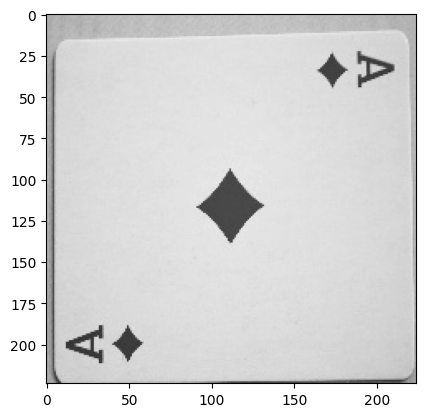

In [8]:
# Test if an image is actually gray

test_colored_image = 'train/ace of diamonds/001.jpg'
test_gray_img = convert_to_grayscale(test_colored_image)
plt.imshow(test_gray_img, cmap='gray', vmin=0, vmax=255)

## Image Enhancement

Apply techniques to improve the image quality or highlight specific features. Includes contrast stretching, histogram equalization, and sharpening

In [9]:
# CONTRAST STRETCHING
# def contrast_stretch(image):
#     min_val = image.min()
#     max_val = image.max()
#     stretched = exposure.rescale_intensity(image, in_range=(min_val, max_val))
#     return stretched

# # HISTOGRAM EQUALIZATION
# def clahe(image):
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     equalized = clahe.apply(contrast_stretch(image)) 
#     return equalized

# BLURRING AND SHARPENING
# Blurring the image
def blur_image(image):
    blur_img = gaussian(image, sigma = 3)
    return blur_img

# Sharpening image
def sharpen_image(image):
    blurred_image = blur_image(image)
    sharp_img = image + (image - blurred_image)
    return sharp_img

# NORMALIZATION
def normalize_img(image):
    normalized = (sharpen_image(image) - np.min(sharpen_image(image)))/(np.max(sharpen_image(image)) - np.min(sharpen_image(image)))   
    return normalized

### Data Augmentation
Apply data augmentation techniques to increase the size and diversity of dataset. This include rotations, flips, and augmentation. This simulate different viewpoints or variations.

In [10]:
#AUGMENTATION FUNCTIONS

#specified rotation
def image_rotation(image, angle_of_rotation):
    
    #rotate the image based on the rotation angle provided
    rotate_img = rotate(image, angle_of_rotation, resize = True)
    
    #resize the image if the size changed
    if rotate_img.shape != image.shape:
        rotated_img = resize(rotate_img, image.shape)
    else:
        rotated_img = rotate_img
     
    #return the final image
    return rotated_img


#random rotation function
def random_rotation(image):
    
    #randomly determine the rotation angle
    random_rotation = np.random.uniform(low = 0.0, high = 360.0)
    
    #rotate the image
    rotate_img = rotate(image, random_rotation, resize = True)
    
    #resize the image if the size changed
    if rotate_img.shape != image.shape:
        rotated_img = resize(rotate_img, image.shape)
    else:
        rotated_img = rotate_img
        
    #return the final image
    return rotated_img


#random flipping function
def random_flip(image):
    
    #generate a method to determine how the image should be flipped
    random_flip_axis = np.random.randint(low = 1, high = 4, dtype = int)
    
    #flip horizontal
    if random_flip_axis == 1:
        flipped_image = image[:, ::-1]
     
    #flip vertical
    elif random_flip_axis == 2:
        flipped_image = image[::-1, :]
    
    #No flip    
    elif random_flip_axis == 3:
        flipped_image = image
    
    #return the flipped image
    return flipped_image
 

#gamma correction - adjusts brightness of image
def gamma_correction(image):
    random_gamma = np.random.uniform(low = 0, high = 1)
    
    gamma_adjusted_image = exposure.adjust_gamma(image, 2)
    return gamma_adjusted_image


#logarithmic correction - replaces pixels with their log value
def log_correction(image):
    log_adjusted_image =  exposure.adjust_log(image)
    return log_adjusted_image


#data augmentation function
def data_augmentation(image):
    random_correction = np.random.randint(low = 1, high = 4, dtype = int)
    
    rotated_image = random_rotation(image)
    flipped_image = random_flip(rotated_image)
    
    #random correction of the image
    if random_correction == 1:
        augmentated_image = gamma_correction(flipped_image)
        
    elif random_correction == 2:
        augmentated_image = log_correction(flipped_image)
    
    elif random_correction == 3:
        augmentated_image = flipped_image
    
    return augmentated_image

### Test all functions and display images

NameError: name 'contrast_stretch' is not defined

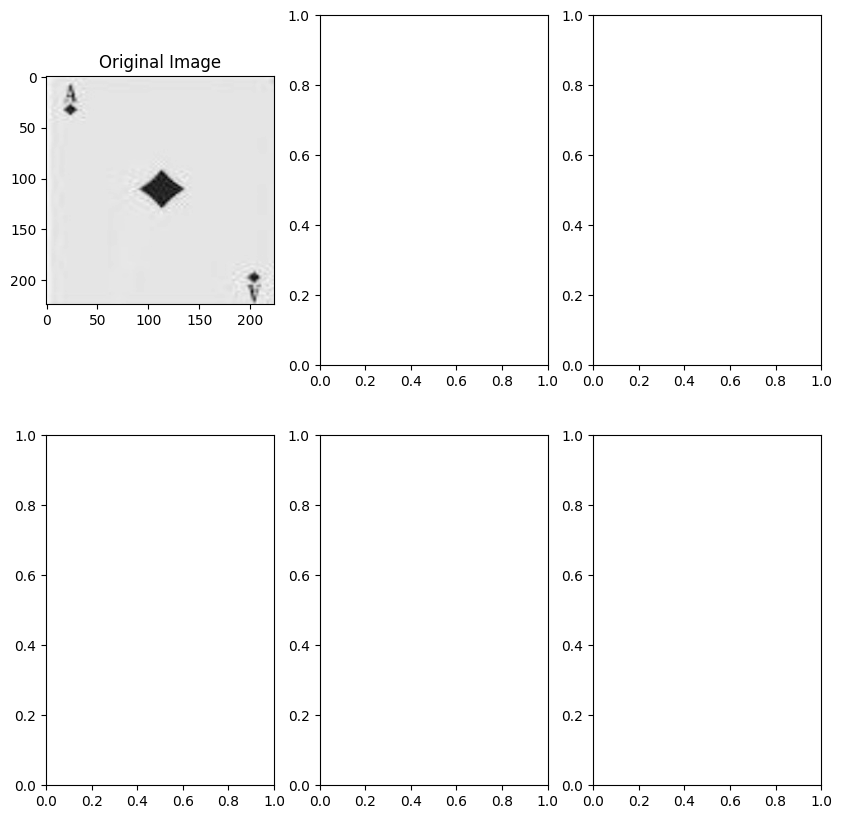

In [11]:
# Test functions and display images

test_colored_image = 'train/ace of diamonds/112.jpg'
test_gray_img = convert_to_grayscale(test_colored_image)
gray_img = test_gray_img

fig, axes = plt.subplots(2,3, figsize = (10,10))

axes[0,0].imshow(gray_img, cmap = 'gray')
axes[0,0].set_title('Original Image')

axes[0,1].imshow(contrast_stretch(gray_img), cmap = 'gray')
axes[0,1].set_title('Contrast Stretch Image')

axes[0,2].imshow(clahe(gray_img), cmap = 'gray')
axes[0,2].set_title('Histogram Equalization Image')

axes[1,0].imshow(blur_image(gray_img), cmap = 'gray')
axes[1,0].set_title('Blurred Image')

axes[1,1].imshow(sharpen_image(gray_img), cmap = 'gray')
axes[1,1].set_title('Sharpened Image')

axes[1,2].imshow(normalize_img(gray_img), cmap = 'gray')
axes[1,2].set_title('Normalized Image')

plt.tight_layout()
plt.show()


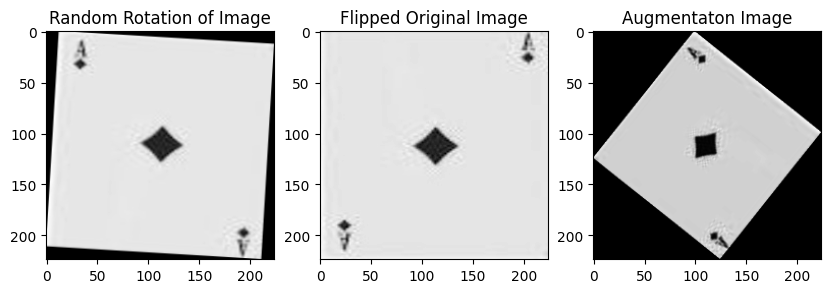

In [12]:
#Displaying of Augmented Images
rotated_img = random_rotation(normalize_img(gray_img)) #random rotation

flipped_original_image = random_flip(normalize_img(gray_img)) #flipping the original image

augmentated_image = data_augmentation(normalize_img(gray_img)) #data augmentation funtion

#plotting the flipped and rotated images
fig, axes = plt.subplots(1,3, figsize = (10,10))

axes[0].imshow(rotated_img, cmap = 'gray')
axes[0].set_title('Random Rotation of Image')

axes[1].imshow(flipped_original_image, cmap = 'gray')
axes[1].set_title('Flipped Original Image')

axes[2].imshow(augmentated_image, cmap = 'gray')
axes[2].set_title('Augmentaton Image')

plt.show()

### Consolidate enhanced images and augmented images

In [14]:
all_images = []
all_labels = []

# g = convert_to_grayscale('train/ace of diamonds/112.jpg')

# directory = os.path.dirname('train/ace of diamonds/112.jpg')
# print(directory)
# os.makedirs(directory, exist_ok=True)
# save_path = os.path.join(directory, os.path.basename('train/ace of diamonds/112.jpg'))
# print(save_path)
# cv2.imwrite(save_path, g)

for index, row in path_df.iterrows():
    filepath = row['filepaths']
    image = convert_to_grayscale(filepath)
    preprocessed_image = normalize_img(image)
    scaled_preprocessed_image = (preprocessed_image * 255).astype(np.uint8)
#     augmented_image = data_augmentation(image)
#     scaled_augmented_image = (scaled_image * 255).astype(np.uint8)
    
    # save preprocessed images to new DatasetPreProcessed folder
    directory = os.path.split('/workspace/ucb_mids_w281_project/DatasetPreProcessed/' + filepath)[0]
    os.makedirs(directory, exist_ok=True)
    save_path = os.path.join(directory, os.path.basename(filepath))

    # save normalized images
    cv2.imwrite(save_path, scaled_preprocessed_image)
# #     # save augmented images
# #     cv2.imwrite(save_path, augmented_image)
    
    
#     all_images.append(normalize_img(image))
#     all_images.append(data_augmentation(image))
    


# print(len(all_images))

In [ ]:
all_images = []
all_labels = []

for index, row in path_df.iterrows():
    filepath = row['filepaths']
    label = row['class_index']
    image = convert_to_grayscale(filepath)
    preprocessed_image = normalize_img(image)
    scaled_preprocessed_image = (preprocessed_image * 255).astype(np.uint8)
    augmented_image = data_augmentation(image)
    scaled_augmented_image = (scaled_image * 255).astype(np.uint8)
    

    all_images.append(normalize_img(image))
    all_labels.append(label)
    all_images.append(data_augmentation(image))
    all_labels.append(label)
    
print(len(all_images))
print(len(all_labels))

In [ ]:
print(type(all_images))

In [ ]:
# all_images = []
# all_labels = []

# normalized_images = []
# normalized_images_labels = []

# for index, row in path_df.iterrows():
#     filepath = row['filepaths']
#     label = row['suit']
#     try:
#         image = convert_to_grayscale(filepath)
#         if image is not None and filepath.endswith('.jpg'):
#             # Perform any necessary preprocessing on the image
#             normalized_images.append(normalize_img(image))
#             normalized_images_labels.append(label)
#         else:
#             continue
#     except Exception as e:
#             continue

# print(normalized_images[0:5])

# # append augmented images
# for i in range(len(normalized_images)):    
#     all_images.append(normalized_images[i])
#     all_labels.append(normalized_images_labels[i])
    
    
#     augmented_image = data_augmentation(normalized_images[i])
#     augmented_image_label = normalized_images_labels[i]
    
#     all_images.append(augmented_image)
#     all_labels.append(augmented_image_label)
    
# print(len(normalized_images))
# print(len(normalized_images_labels))
# print(len(all_images))
# print(len(all_labels))

### Train-Train-Validation Split

In [ ]:
# Splitting into train, test, and validation sets (80% - 10% - 10% split)
X_train, X_test_val, y_train, y_test_val = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

In [ ]:
custom_df = pd.DataFrame({'image_pixels': all_images, 'labels': all_labels})

In [ ]:
custom_df.head()

In [ ]:
# Split dataframe into train and test sets
train_df, test_df = train_test_split(custom_df, test_size=0.2, random_state=42)

# Split train set into train and validation sets
test_df, val_df = train_test_split(train_df, test_size=0.5, random_state=42)

In [15]:
path_df.head()

,class_index,filepaths,labels,card_type,data_set,suit
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train,clubs
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train,clubs
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train,clubs
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train,clubs
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train,clubs


In [16]:
path_df = path_df.drop(columns = ['data_set'])
path_df.head()

,class_index,filepaths,labels,card_type,suit
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,clubs
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,clubs
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,clubs
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,clubs
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,clubs


In [17]:
path_df['filepaths'] = path_df['filepaths'].apply(lambda x: 'DatasetPreProcessed/' + x)
path_df.head()

,class_index,filepaths,labels,card_type,suit
0,0,DatasetPreProcessed/train/ace of clubs/001.jpg,ace of clubs,ace,clubs
1,0,DatasetPreProcessed/train/ace of clubs/002.jpg,ace of clubs,ace,clubs
2,0,DatasetPreProcessed/train/ace of clubs/003.jpg,ace of clubs,ace,clubs
3,0,DatasetPreProcessed/train/ace of clubs/004.jpg,ace of clubs,ace,clubs
4,0,DatasetPreProcessed/train/ace of clubs/005.jpg,ace of clubs,ace,clubs


In [18]:
# Split dataframe into train and test sets
train_df, test_df = train_test_split(path_df, test_size=0.2, random_state=42)

# Split train set into train and validation sets
test_df, val_df = train_test_split(train_df, test_size=0.5, random_state=42)

In [19]:
image_size = [224, 224]

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size + [3]))

print(base_model.summary())

2023-07-16 02:34:03.229121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-16 02:34:03.262088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-16 02:34:03.262138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-16 02:34:03.264856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-16 02:34:03.264897: I tensorflow/compile

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [20]:
# Don't want to train model because it is already trained.
for layer in base_model.layers:
    layer.trainable = False

In [21]:
flatten_layer = Flatten()(base_model.output)
prediction  = Dense(52, activation='softmax')(flatten_layer)
model = Model(inputs=base_model.input, outputs=prediction)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [22]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [24]:
train_data_generator = ImageDataGenerator(rescale = 1. /255,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

test_data_generator = ImageDataGenerator(rescale=1. /255)

# training_set = train_data_generator.flow_from_directory(train_folder, target_size=(224,224), batch_size=32, class_mode='categorical')
# test_set = test_data_generator.flow_from_directory(val_folder, target_size=(224,224), batch_size=32, class_mode='categorical')


training_set = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224), 
    batch_size=32, 
    class_mode='categorical')

val_set = test_data_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224), 
    batch_size=32, 
    class_mode='categorical')

test_set = test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224), 
    batch_size=32, 
    class_mode='categorical')




Found 6423 validated image filenames belonging to 52 classes.
Found 3212 validated image filenames belonging to 52 classes.
Found 3211 validated image filenames belonging to 52 classes.


In [25]:
result = model.fit(training_set, 
                   validation_data=val_set, 
                   epochs=10,
                   steps_per_epoch=len(training_set),
                   validation_steps=len(val_set))

Epoch 1/10


2023-07-16 02:34:51.544848: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-16 02:34:53.524485: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-07-16 02:34:54.187079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-16 02:34:55.048858: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x563bd5081e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-16 02:34:55.048901: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-07-16 02:34:55.11226

  1/201 [..............................] - ETA: 13:28 - loss: 4.6654 - accuracy: 0.0000e+00

2023-07-16 02:34:55.534541: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


201/201 [==============================] - ETA: 0s - loss: 8.6967 - accuracy: 0.1577

2023-07-16 02:35:26.859664: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


201/201 [==============================] - 45s 207ms/step - loss: 8.6967 - accuracy: 0.1577 - val_loss: 4.6434 - val_accuracy: 0.2989
Epoch 2/10
201/201 [==============================] - 40s 199ms/step - loss: 4.8990 - accuracy: 0.2776 - val_loss: 4.9861 - val_accuracy: 0.3811
Epoch 3/10
201/201 [==============================] - 40s 196ms/step - loss: 4.6795 - accuracy: 0.3304 - val_loss: 4.0754 - val_accuracy: 0.4004
Epoch 4/10
201/201 [==============================] - 40s 196ms/step - loss: 4.7106 - accuracy: 0.3553 - val_loss: 4.2959 - val_accuracy: 0.4060
Epoch 5/10
201/201 [==============================] - 39s 194ms/step - loss: 4.3357 - accuracy: 0.3922 - val_loss: 3.3089 - val_accuracy: 0.4847
Epoch 6/10
201/201 [==============================] - 39s 194ms/step - loss: 4.2450 - accuracy: 0.4143 - val_loss: 3.2671 - val_accuracy: 0.5143
Epoch 7/10
201/201 [==============================] - 64s 320ms/step - loss: 4.0869 - accuracy: 0.4319 - val_loss: 3.6323 - val_accuracy: 0.5

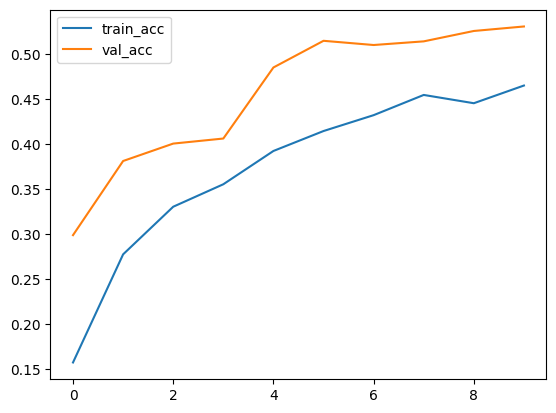

In [26]:
#Plot accuracy
plt.plot(result.history['accuracy'], label='train_acc')
plt.plot(result.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

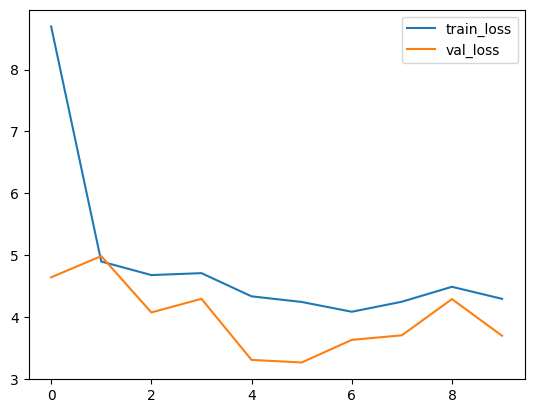

In [27]:
#Plot Loss
plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [28]:
# Evaluate the model on the test set
evaluation = model.evaluate(test_set, steps=len(test_set))

# Print the evaluation metrics
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])


2023-07-16 02:43:28.845161: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


101/101 [==============================] - 25s 247ms/step - loss: 3.6817 - accuracy: 0.5179
Loss: 3.681736469268799
Accuracy: 0.5179072022438049


In [29]:
# Perform predictions on the test set
predictions = model.predict(test_set, steps=len(test_set))

# Convert the predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Print the predicted labels
print(predicted_labels)


2023-07-16 02:44:14.000528: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


101/101 [==============================] - 24s 232ms/step
[20 41  6 ... 47 11  3]


In [30]:
# Ground truth labels for the test set
true_labels = test_set.labels

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='macro')

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='macro')

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.016332664735859804
Recall: 0.017396272942698937
F1 Score: 0.014345942379043512


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Image Filtering

Apply filters or convolutions to smooth the image or enhance specific features. This can include techniques such as blurring (e.g., Gaussian blur), edge detection (e.g., Sobel, Canny), or other spatial filters.

In [ ]:
#THRESHOLDING, BINARIZATON AND FILLING OF IMAGES

test_colored_image = 'train/ace of diamonds/001.jpg'
test_gray_img = convert_to_grayscale(test_colored_image)
gray_img = test_gray_img

img = sharpen_image(gray_img)

#thresholding Image
def thresholding_image(image):
    
    threshold_image = threshold_otsu(image)
    return threshold_image

#binarizing image
def binarizing_image(image):
    
    binary_image = image > thresholding_image(image)
    return binary_image

#filling image, best results are based on a binarized image
def fill_image(image):
    
    filled_image = binary_fill_holes(image)
    return filled_image
    

figs, axes = plt.subplots(1,3, figsize = (10,10))

axes[0].imshow(img, cmap = 'gray')
axes[0].set_title('Sharpened Image')

axes[1].imshow(binarizing_image(img), cmap = 'gray')
axes[1].set_title('Binarized Image')

axes[2].imshow(fill_image(binarizing_image(img)), cmap = 'gray')
axes[2].set_title('Filled Image')

plt.show()

In [ ]:
#EDGE DETECTION USING CANNY AND SOBEL METHODS

binary_img = binarizing_image(img)
filled_bin = fill_image(binarizing_image(img))

#sobel method
sobel_edge_img = sobel(gray_img)
sobel_binary_edge_img = sobel(binary_img) #thresholding with no filling
sobel_filled_edge_img = sobel(filled_bin) #filled image with thresholding

#canny method
canny_edge_img = canny(gray_img, sigma = 3)
canny_binary_edge_img = canny(binary_img, sigma = 3) #thresholding with no filling
canny_filled_edge_img = canny(filled_bin, sigma = 3) #filled image with thresholding

#plot images
figs, axes = plt.subplots(2,3, figsize = (10,10))

axes[0,0].imshow(sobel_edge_img, cmap = 'gray')
axes[0,0].set_title('sobel_edge_img')

axes[0,1].imshow(sobel_binary_edge_img, cmap = 'gray')
axes[0,1].set_title('sobel_binary_edge_img')

axes[0,2].imshow(sobel_filled_edge_img, cmap = 'gray')
axes[0,2].set_title('sobel_filled_edge_img')

axes[1,0].imshow(canny_edge_img, cmap = 'gray')
axes[1,0].set_title('canny_edge_img')

axes[1,1].imshow(canny_binary_edge_img, cmap = 'gray')
axes[1,1].set_title('canny_binary_edge_img')

axes[1,2].imshow(canny_filled_edge_img, cmap = 'gray')
axes[1,2].set_title('canny_filled_edge_img')

plt.show()

In [ ]:
#CALCULATING ANGLES OF ROTATION
#Imperfect. None of the methods used produced a reliable angle of rotation

import warnings
warnings.filterwarnings('ignore')

def hough_line_detection(h_img, title):
    '''
    We can determing the angle of rotation based on the angle between the identified hough lines (theta) detected
    '''
    h, theta, d = hough_line(h_img)
    besth, besttheta, bestd = hough_line_peaks(h, theta, d)
    
    if len(besttheta) > 0:
        r_angle = np.rad2deg(mode(besttheta)[0][0])
        
    else:
        r_angle = 0
#     print(f'{title}, rotation angle: {r_angle}')
    return r_angle

#rotation angle based on the different edge detection methods used

se_img = hough_line_detection(sobel_edge_img, 'sobel edge')
sbe_img = hough_line_detection(sobel_binary_edge_img, 'sobel edge with threshold and no fill')
sfe_img = hough_line_detection(sobel_filled_edge_img, 'sobel edge with threshold and fill')

ce_img = hough_line_detection(canny_edge_img, 'canny edge ')
cbe_img = hough_line_detection(canny_binary_edge_img, 'canny edge with threshold and no fill')
cfe_img = hough_line_detection(canny_filled_edge_img, 'canny edge with threshold and fill')